# Train Your Own Word Embeddings With Autoencoders

In [1]:
import numpy as np
from noggin import create_plot
from gensim.models.keyedvectors import KeyedVectors
import codecs
from nltk.tokenize import word_tokenize

%matplotlib notebook

## Quantifying Context

We will begin by ascribing words numerical representations based solely on the contexts in which they occur; that is, we will represent words based on the words that commonly occur around them. 

For example, the sentences "dogs are loud pets" and "cats are quiet pets" not only draw similarities and distinctions between cats and dogs, but these sentences also begin to convey some meaning for the word "pet". By tracking the words that commonly occur in the midst of "pet" across many documents, we hope to arrive at a coherent numerical representation of "pet" that is able encode that the words "cat", "dog", "parakeet", "owner", "care", "train" are all relevant to the concept of "pet".  

Obviously, we will need to define what we mean by "context", and define a window size that we use when "scanning" our text. 

To begin, we will construct a "context matrix" of the counts of words appearing within a certain distance of other words. More specifically, for each word in our corpus, we will count the appearances of all other words within a context window.

Each row of the context matrix corresponds to a unique word in our corpus; we will update that word's row when it occurs in the center of a context window.
For a given row, the values of the content matrix are the tallies of the appearances of other words within the context window (the number of co-occurences of context words).  So, if $X_{i,j}$ is the value of element $(i,j)$, our context matrix can be interpreted as:
> for all appearances of word $i$ in the center of the context window, word $j$ had $X_{i,j}$ number of co-occurences with $i$ ($j$ appeared $x$ number of times within the specified context window around word $i$)


As an example, for the sentence
> i am scared of dogs

the word "scared" is in the center of a context window of $2$ words on either side. Then for each of the words contained within the context window, we would increment the element in the row corresponding to "scared" and the column corresponding to the context word. 

Because this matrix can grow very large as the vocabulary size grows, we will restrict the size of the vocabulary to the most frequent `max_vocab_words` words (again removing the common "glue" words that help make language interpretable, but not meaningful). To make it feasible to train our model, we will also restrict the number words that we consider context words to the most frequent `max_context_words` words. Note that this `max_context_words` restriction is not the same as reducing the length of our context window: we are actually limiting the vocabulary size of context words to the most common `max_context_words` words in the full vocabulary.

Once again, we will use `nltk` to tokenize our data. However, because each of our vocab words will correspond to a row in our context matrix, we should assign a unique integer code to each unique word. Below are three convinience functions for this conversion. 

`generate_sorted_words` will sort our tokens by count so that more frequent words will correspond to lower value codes (and thus smaller indices in the context matrix). This will make it much easier to filter our `max_vocab_words`.

`generate_word2code` will take in a list of words sorted by number of appearances and assign each unique word to an integer code.

Lastly, `convert_tokens_to_codes` will take an unordered list of tokens and return a list of the corresponding codes for each token.

Complete the functions below, and test to make sure that each works as desired.

In [6]:
def generate_sorted_words(tokens):
    """ Create list of unique words sorted by count in descending order
        
    Parameters
    ----------
    tokens: List[str]
        A list of tokens (words), e.g., ["the", "cat", "in", "the", "in", "the"]

    Returns
    -------
    List[str]
        A list of unique tokens sorted in descending order of occurence, e.g., ["the", "in", cat"]
    """
    # <COGINST>
    from collections import Counter
    
    counter = Counter(tokens)
    words = [word for word, count in counter.most_common()]
    return words
    # </COGINST>

In [7]:
# Test your code
generate_sorted_words(["the", "cat", "in", "the", "in", "the"]) == ["the", "in", "cat"]

True

In [8]:
def generate_word2code(sorted_words):
    """ Create a dictionary that maps a word to its position in the count-sorted list of words
    
    Parameters
    ---------
    sorted_words: List[str]
        A count-sorted list of unique words, e.g., ["bat", "apple", "cat"]

    Returns
    -------
    Dict[str, int]
        A dictionary that maps a word to an integer code, e.g., {"bat": 0, "apple": 1, "cat": 2}
    """
    return {word: index for index, word in enumerate(sorted_words)}  # <COGLINE>

In [9]:
# Test your code
generate_word2code(["bat", "apple", "cat"]) == {"bat": 0, "apple": 1, "cat": 2}

True

In [10]:
def convert_tokens_to_codes(tokens, word2code):
    """ Convert tokens to codes.
    
        Parameters
    ---------
    tokens: List[str]
        A list of N words, e.g., ["bat", "cat", "apple"]
        
    word2code: Dict[str, int]
        A dictionary mapping words to integer codes, e.g., {"apple": 0, "bat": 1, "cat": 2}

    Returns
    -------
    np.ndarray, shape-(N,)
        An array of integer codes corresponding to the input words, e.g., [1, 2, 0].
    """
    return np.array([word2code[token] for token in tokens]) # <COGLINE>

In [11]:
# Test your code
convert_tokens_to_codes(["bat", "cat", "apple"], {"apple": 0, "bat": 1, "cat": 2}) == np.array([1, 2, 0])

array([ True,  True,  True])

For the example tokens `["a", "a", "b", "c", "c", "c", "c", "a", "b", "c"]`, what do you expect the output of each of your functions to be? Do your functions match this expected behaviour?

In [12]:
tokens = ["a", "a", "b", "c", "c", "c", "c", "a", "b", "c"]
# <COGINST>
sorted_words = generate_sorted_words(tokens)
print(sorted_words)

word2code = generate_word2code(sorted_words)
print(word2code)

codes = convert_tokens_to_codes(tokens, word2code)
print(codes)
# </COGINST>

['c', 'a', 'b']
{'c': 0, 'a': 1, 'b': 2}
[1 1 2 0 0 0 0 1 2 0]


We will use the following function, `generate_word_by_context`, to construct our context matrix. See the pseudo-code below for tally up co-occurrence counts between words using nested for-loops: 
```
Initialize a 2D array of zeros, with shape-(max_vocab_words, max_context_words)

Slide window along sequence, starting with the first center word, and begin tallying
    co-occurrences between words within a context window.
    
if code of center word is >= max_vocab_words:
    skip
    
for each word in context (on left and right sides)
    if code of context word < max_context_words
        add 1.0 to matrix element in row-(center word) and column-(context word)
            or (if weighting by distance)
        add 1.0 / (distance from center to context)
```

As an example, assume context_size is $2$ (i.e., $2$ words to left and $2$ words to right of the center word). If our vocabulary is just `["a", "b", "c"]`, the following diagram shows how we slide out window across the text as well as the various numerical representations (i.e. word-code and word-position) for the text.

```python 
"a" "a" "b" "c" "c" "c" "c" "a" "b" "c"   # sequence of words (for this example, we use letters)
 1   1   2   0   0   0   0   1   2   0    # corresponding sequence of word-codes; determined by word-count
 0   1   2   3   4   5   6   7   8   9    # position in sequence
[        ^        ]                       # first window: centered on position 2; center word has code 2
    [        ^        ]                   # second window: centered on position 3; center word has code 0
                ...                 
                    [        ^        ]   # last window: centered on position 7; center word has code 1

```

This will lead to slow performance in pure Python. **Write your function using for-loops anyway and verify that it passes the test cases provided below.** 

**Once your function passes the test cases**, we will use a special decorator, `numba.njit` to compile an optimized version of your function. Import `njit` via: `from numba import njit`. Then decorate your function by adding `@njit` to the top of the function definition:

```python
@njit
def generate_word_by_context(codes, max_vocab_words=1000, max_context_words=1000, 
                             context_size=2, weight_by_distance=True):
   ...
```

and re-run the cell to redefine your function. Try running your now-decorated function on the test cases again. If you get an error, or your Jupyter kernel dies without warning, have an instructor come by to help make your code numba compatible. 

How does `njit` improve the performance of our function though? Numba is a library designed to compile a subset of Python/NumPy code down to optimized instructions for low-level virtual machine (LLVM). You can call your function as usual, but it will be executed in this LLVM. This can accelerate your code greatly: here, we will see a speedup of ~$100$x ($2$ minutes $\rightarrow$ $2$ seconds). Sadly Numba only supports a small subset of the Python language, and so we cannot simply throw the `njit` decorator on all our code.

In [14]:
from numba import njit


@njit
def generate_word_by_context(
    codes,
    max_vocab_words=1000,
    max_context_words=1000,
    context_size=2,
    weight_by_distance=True,
):
    """ Creates array of vocab word by context word (possibly weighted) co-occurrence counts.
    
    Parameters
    ----------
    codes: numpy.ndarray, shape-(N,)
        A sequence of word codes (integers).
        
    max_vocab_words: int
        The max number of words to include in vocabulary (will correspond to rows in matrix).
        This is equivalent to the max word code that will be considered/processed as the center 
        word in a window.
        
    max_context_words: int
        The max number of words to consider as possible context words (will correspond to columns 
        in a 2D array).
        This is equivalent to the max word code that will be considered/processed when scanning 
        over contexts.
        
    context_size: int
        The number of words to consider on both sides (i.e., to the left and to the right) of the 
        center word in a window.
        
    weight_by_distance: bool
        Whether or not the contribution of seeing a context word near a center word should be 
        (down-)weighted by their distance:

            False --> contribution is 1.0
            True  --> contribution is 1.0 / (distance between center-word position and context-word)

        For example, suppose ["i", "am", "scared", "of", "dogs"] has codes [45, 10, 222, 25, 88]. 

        With weighting False, 
            X[222, 45], X[222, 10], X[222, 25], and X[222, 88] all get incremented by 1.

        With weighting True, 
            X[222, 45] += 1.0/2  <-- distance between "i" and "scared" is 2
            X[222, 10] += 1.0/1  <-- distance between "am" and "scared" is 1
            X[222, 25] += 1.0/1  <-- distance between "of" and "scared" is 1
            X[222, 88] += 1.0/2  <-- distance between "dogs" and "scared" is 2

    Returns
    -------
    ndarray, shape=(max_vocab_words, max_context_words)
        An array where rows are vocab words, columns are context words, and values are
        (possibly weighted) co-occurrence counts.
    """
    # initialize 2d array of zeros (with dtype=np.float32 to reduce required memory)
    X = np.zeros((max_vocab_words, max_context_words), dtype=np.float32)  # <COGLINE>

    # slide window along sequence and count "center word code" / "context word code" co-occurrences
    # Hint: let main loop index indicate the center of the window
    # <COGINST>
    # iterate over center-words
    for word_pos in range(context_size, len(codes) - context_size):
        center_code = codes[word_pos]
        
        if center_code >= max_vocab_words:
            continue
        
        # iterate within window
        for j in range(-context_size, context_size + 1):
            if j == 0:
                continue
            context_code = codes[word_pos + j]
            if context_code < max_context_words:
                value = 1.0
                if weight_by_distance:
                    value = 1.0 / abs(j)
                X[center_code, context_code] += value
    return X
    # </COGINST>

You can test your implementation of `generate_word_by_context` below, using the sequence `[2, 3, 4, 9, 6, 7]`. The value of `context_matrix` should be
```python
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
```
since there are only two full windows as we slide along: `[2, 3, 4, 9, 6]` and `[3, 4, 9, 6, 7]`.

In the first window, the code of the center word is 4, and it co-occurs with codes 2 and 3 on its left and codes 9 and 6 on its right. Since code 9 is greater than the maximum context words, its co-occurence is not encoded into the matrix.

In the second window, the code of the center word is 9, with co-occurences of 3 and 4 on the left and 6 and 7 on the right. However, as 9 is also outside the maximum number of vocabulary codes, this entire window is excluded from `context_matrix`.

In [15]:
# assume this sequence already contains word codes
sequence = np.array([2, 3, 4, 9, 6, 7])
context_matrix = generate_word_by_context(
    sequence,
    max_vocab_words=8,
    max_context_words=8,
    context_size=2,
    weight_by_distance=False,
)
print(context_matrix)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


Now test with `weight_by_distance=True`. When weighting by distance, `context_matrix` should have the value:
```python
[[ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  1.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]]
```

There is still only one full window which contributes to `context_matrix`, but now context words that are farther away from the center word contribute a lower weight. Directly adjacent context words will still contribute $\frac{1}{1}=1$, but context words on the edge of the window will now only contribute $\frac{1}{2}=0.5$.

In [16]:
# turn on weighting
context_matrix = generate_word_by_context(
    sequence,
    max_vocab_words=8,
    max_context_words=8,
    context_size=2,
    weight_by_distance=True,
)
print(context_matrix)

[[0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 1.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]


Now let's load in the data we will train on. We'll use the same Wikipedia data we used when training our n-gram model. We will also use `nltk`'s tokenizer, while leaving in punctuation (which GloVe does as well).
This might take a few minutes to run.

In [17]:
from cogworks_data.language import get_data_path
import nltk
nltk.download('punkt')

path_to_wikipedia = get_data_path("wikipedia2text-extracted.txt")

with open(path_to_wikipedia, "rb") as f:
    wikipedia = f.read().decode().lower()
print(f"{len(wikipedia)} character(s)")

tokens = word_tokenize(wikipedia.lower())
print(f"{len(tokens)} tokens(s)")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


63591333 character(s)
11614069 tokens(s)


Using the functions you created earlier, convert the tokens into codes.

In [27]:
# <COGINST>
sorted_words = generate_sorted_words(tokens)
word2code = generate_word2code(sorted_words)
codes = convert_tokens_to_codes(tokens, word2code)
del tokens
# </COGINST>

Now create your context matrix, choosing your `max_vocab_words` and `max_context_words`. Take caution though and consider how big of an array will be created! Also choose a context window size.

(We recommend `max_vocab_words=10_000`,  `max_context_words=1000`, `context_size=4`, `weight_by_distance=True`).

In [29]:
# <COGINST>
# how many words to keep in vocabulary (will have one row per vocab word)
max_vocab_words = 10_000

# how many words to treat as potential context words (will have one column per context word)
max_context_words = 1000

x_wiki = generate_word_by_context(
    codes,
    max_vocab_words=max_vocab_words,
    max_context_words=max_context_words,
    context_size=4,
    weight_by_distance=True,
)
# </COGINST>

Before we start training a neural network to learn word embeddings, take the $\log_{10}$ of the context matrix. 
This has been shown to improve performance, as the data are scaled to a more reasonable domain for the network to learn on.
However, since the vast majority of elements in our context matrix will be $0$, we will want to shift all elements in our context matrix by a constant.

If we want all the elements that are initially $0$ to once again be $0$ after taking the logarithm, what should we choose this constant to be?
We will want to add $1$ to each element in our context matrix before taking the logarithm.

In [30]:
# compute `context_matrix = np.log10(1 + context_matrix)`
context_matrix = np.log10(1 + x_wiki, dtype="float32", out=x_wiki) # <COGLINE>

### Using Our Context Matrix

We now have our log-scaled context matrix:

\begin{align}
&\:\begin{matrix}\xleftarrow{\hspace{0.95em}} & C & \xrightarrow{\hspace{0.95em}}\end{matrix} \\
X =\;\, &\begin{bmatrix}\leftarrow & \vec{x}_1 & \rightarrow \\ \leftarrow & \vec{x}_2 & \rightarrow \\ \vdots & \vdots & \vdots \\ \leftarrow & \vec{x}_{N_{\mathrm{vocab}}} & \rightarrow\end{bmatrix}\;\;\begin{matrix}\bigg\uparrow \\ N_{\mathrm{vocab}} \\ \bigg\downarrow\end{matrix}
\end{align}

where $C$ is the value of `max_context_words` that we passed to `generate_word_by_context(...)`.
We want to learn a shape-$(C, D)$ matrix, $W_{\mathrm{encode}}$, that reduces the dimensionality of each of these $C$-dimensional context vectors to corresponding $D$-dimensional vectors, where $D$ is a value of our choosing and $D < C$.

Thus if we pick our the $C$-dimensional context vector for, say, the word "lion", we will have:

\begin{align}
&\begin{bmatrix}\leftarrow & \vec{x}_{\mathrm{lion}} & \rightarrow \end{bmatrix} W_{\mathrm{encode}} = \begin{bmatrix}\leftarrow & \vec{h}_{\mathrm{lion}} & \rightarrow \end{bmatrix}
\end{align}

where $\vec{h}_{\mathrm{lion}}$ is the $D$-dimensional word-embedding for the word "lion".

How do we find values for $W_{\mathrm{encode}}$?
We will use gradient descent to train an auto-encoder such that:

\begin{align}
X W_{\mathrm{encode}} W_{\mathrm{decode}} &\approx X \\
(N, C) (C, D) (D, C) &\rightarrow (N, C) \\
\end{align}

where $W_{\mathrm{decode}}$ is a shape-$(D, C)$ matrix that maps our shape-$(D,)$ embedding vector back to the $C$-dimensional context space, and $N$ is our batch size.
Ultimately we will not need to use $W_{\mathrm{decode}}$ outside of the context of aiding in training our encoding matrix.

## Setting Up Our Autoencoder

We will train a linear autoencoder using a two-layer dense network, as we had before.

Create your MyNN model below. Use the `glorot_normal` initializer as the weight initializer for both the encoder and decoder. Do **not** include a bias term for either layer and do **not** include an activation function.

In [31]:
from mynn.layers.dense import dense
from mygrad.nnet.initializers import glorot_normal

class Autoencoder:
    def __init__(self, context_words, d):
        """ Initializes all of the encoder and decoder layers in our model, setting them
        as attributes of the model.
        
        Parameters
        ----------
        context_words : int
            The number of context words included in our vocabulary
            
        d : int
            The dimensionality of our word embeddings
        """
        # <COGINST>
        self.encode = dense(context_words, d, weight_initializer=glorot_normal, bias=False)
        self.decode = dense(d, context_words, weight_initializer=glorot_normal, bias=False)
        # </COGINST>
    
    
    def __call__(self, x):
        ''' Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, context_words)
            A batch of data consisting of M words from the context matrix,
                each tracking the number of co-occurences with `context_words` words.
                
        Returns
        -------
        mygrad.Tensor, shape=(M, context_words)
            The result of passing the data through borth the encoder and decoder.
        '''
        return self.decode(self.encode(x)) # <COGLINE>
    
    
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model"""
        return self.encode.parameters + self.decode.parameters # <COGLINE>

Below, instantiate your model such that it will learn a 200-dimensional embedding, and initialize an optimizer.
Use the `Adam` optimizer from MyNN with a learning rate of `1e-4`. Also, create a `noggin` plotter to track the loss as we train.

<IPython.core.display.Javascript object>


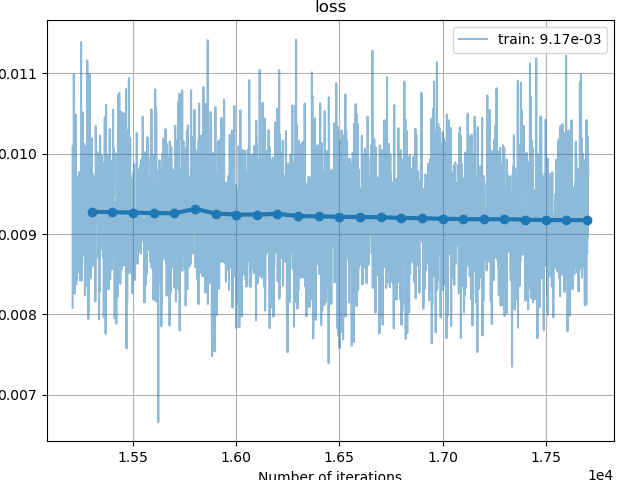

In [32]:
from mynn.optimizers.adam import Adam

# <COGINST>
model = Autoencoder(max_context_words, 200)
optim = Adam(model.parameters, learning_rate=1e-4)
# </COGINST>

plotter, fig, ax = create_plot(metrics="loss", last_n_batches=2500)


Now train your autoencoder! To start, try a batch size of $100$, trained for $180$ epochs. Use MyNN's `mean_squared_loss` as your loss function.

In [33]:
from mynn.losses.mean_squared_loss import mean_squared_loss

# <COGINST>
batch_size = 100

for epoch_cnt in range(180):
    idxs = np.arange(len(x_wiki))
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(0, len(x_wiki) // batch_size):
        batch_indices = idxs[(batch_cnt * batch_size):((batch_cnt + 1) * batch_size)]
        batch = x_wiki[batch_indices]
        
        pred = model(batch)
        loss = mean_squared_loss(pred, batch)

        loss.backward()
        optim.step()

        plotter.set_train_batch({"loss" : loss.item()}, batch_size)
    plotter.set_train_epoch()
# </COGINST>

Now that we have a trained autoencoder, let's create our actual word embeddings. Pass in our full dataset **to the encoder only** and assign the result to `my_vectors`. This will return a tensor - retrieve the underlying NumPy array and assign it to the variable `my_vectors`.

In [34]:
from mygrad import no_autodiff

with no_autodiff:
    my_vectors = model.encode(x_wiki).data # <COGLINE>

Check out first 10 elements of the vector for "king"

In [35]:
my_vectors[word2code["king"]][0:10] # <COGLINE>

array([-0.8310492 , -0.21955802,  0.24245276, -1.7118704 ,  0.00489334,
        0.06088606,  0.66589886, -1.144242  ,  0.41793922, -0.06272995],
      dtype=float32)

Let's save and load back our word vectors into `gensim` so we can use some `gensim` functionality for exploring our word embeddings.

In [36]:
d = 200 # this is the dimensionality of your word embeddings

# save in word2vec format (first line has vocab_size and dimension; other lines have word followed by embedding)
with codecs.open(f"my_vectors_{d}.txt", "w", "utf-8") as f:
    f.write(str(max_vocab_words) + " " + str(d) + "\n")
    
    for i in range(max_vocab_words):
        f.write(sorted_words[i] + " " + " ".join([str(x) for x in my_vectors[i,:]]) + "\n")

# load back in
embeddings = KeyedVectors.load_word2vec_format("my_vectors_200.txt", binary=False)

Let's check out some of the relationships our word embeddings learned. As we did before, use `similar_by_word` to find which words are considered most similar to a specified word. Also, create some analogies and use `similar_by_vector` to find the closest matches.

In [37]:
# <COGINST>
print(embeddings.similar_by_word("red"))

query = embeddings["paris"] - embeddings["france"] + embeddings["germany"]
embeddings.similar_by_vector(query)
# </COGINST>

[('blue', 0.8366720676422119), ('green', 0.8163664937019348), ('white', 0.8124843835830688), ('yellow', 0.7890866994857788), ('cross', 0.7424285411834717), ('black', 0.7359406352043152), ('star', 0.7061277031898499), ('dark', 0.7009724378585815), ('line', 0.7006144523620605), ('light', 0.6840951442718506)]


[('paris', 0.8266003727912903),
 ('berlin', 0.7996792197227478),
 ('moscow', 0.7766915559768677),
 ('munich', 0.7507073283195496),
 ('warsaw', 0.7263517379760742),
 ('prague', 0.7199723124504089),
 ('london', 0.7102884650230408),
 ('vienna', 0.7101240754127502),
 ('athens', 0.7020418047904968),
 ('petersburg', 0.6832602024078369)]

Let's put our word embeddings to the test! The gensim library comes with some methods for qualitatively evaluating how well particular word embeddings do on established benchmark datasets for word similarity and analogy solving. We'll use the `gensim`'s `KeyedVectors.accuracy` method to score our embeddings on a set of analogies from the word2vec researchers.

Each non-comment line of the file is a tuple of 4 words, e.g.,

    Athens Greece Baghdad Iraq

This correponds to the analogy: 

    "Athens" is to "Greece" as "Baghdad" is to ?
    
The accuracy method will try to solve each of the 10000+ analogies in the file, which can take a while. Feel free to derive a shorter set of analogies to speed up the testing if you want.

In [38]:
# code for unpacking results from: https://gist.github.com/iamaziz/8d8d8c08c7eeda707b9e
def unpack_accuracy(results):
    sum_corr = len(results[-1][-1]['correct'])
    sum_incorr = len(results[-1][-1]['incorrect'])
    total = sum_corr + sum_incorr
    percent = lambda a: round(a / total * 100, 2)
    print(f'Total sentences: {total}, Correct: {percent(sum_corr)}%, Incorrect: {percent(sum_incorr)}%')

In [39]:
# This might take a while to run...
from cogworks_data.language import get_data_path

results = embeddings.evaluate_word_analogies(get_data_path("questions-words.txt"))
unpack_accuracy(results)

# It is likely that you will get ~30% accuracy

Total sentences: 6275, Correct: 30.8%, Incorrect: 69.2%


Is the percentage correct good? Note that the form of these analogies are fill in the blank instead of multiple choice (like the style that used to be on the SAT). How might random guessing compare? Discuss with a neighbor.

Try comparing the results of our embeddings to those of the GloVe embeddings. You might notice that the quality isn't as good. This isn't too surprising given that we trained on a much smaller number of words (10M vs 6B) and also truncated the context matrix (due to memory limitations) before even training our autoencoder to learn word embeddings. In any case, our embeddings definitely show evidence of learning something about word relationships!

Try changing some of the hyperparameters we set earlier to see if you can improve the performance of the model. Just be cautious not to blow up your memory!